In [2]:
import scipy.io as sio
import scipy
import os
from utils import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


In [3]:
def import_skeleton_data(action, subject, trial):
    filename = f'Kinect2Dataset/Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_skel']
    else:
        return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df

In [4]:
# Read in all data
trial_end = 4
activity_end = 27
subject_end = 8

master_df = pd.DataFrame({'action': [], 'subject': [], 'trial': [], 'frame': [], 'skeleton_joint':[], 'x':[], 'y':[], 'z':[]})

for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp_df = transform_skeleton_data_to_df(activity, subject, trial)
            master_df = pd.concat([master_df, temp_df])

In [5]:
# Transpose skeleton_joint column
for skeleton in list(master_df.skeleton_joint.unique()):
    temp_df_by_skel = master_df.loc[master_df['skeleton_joint'] == skeleton]
    temp_df_by_skel = temp_df_by_skel.rename(columns={'x': 'x'+str(int(skeleton)), 
                                                      'y': 'y'+str(int(skeleton)), 
                                                      'z': 'z'+str(int(skeleton))})
    temp_df_by_skel = temp_df_by_skel.drop(['skeleton_joint'], axis=1)
    if skeleton == 1.0:
        transformed = temp_df_by_skel
    else:
        transformed = transformed.merge(temp_df_by_skel, on=['action','subject','trial','frame'], how='left')
transformed = transformed.sort_values(by=['action','subject','trial','frame'])

In [6]:
# Compute position of joints relative to hip centre (no. 4)
# Normalize by the distance between hip centre and shoulder centre (no. 2)
transformed["dist_hip_shldr_ctr"] = np.sqrt( (transformed["x2"]-transformed["x4"])*(transformed["x2"]-transformed["x4"]) +
                                          (transformed["y2"]-transformed["y4"])*(transformed["y2"]-transformed["y4"]) +
                                          (transformed["z2"]-transformed["z4"])*(transformed["z2"]-transformed["z4"]) )
for joint in range(1,21):
    if joint == 4:
        continue
    transformed["x4.{0}".format(joint)] = (transformed["x{0}".format(joint)] - transformed["x4"])/transformed["dist_hip_shldr_ctr"]
    transformed["y4.{0}".format(joint)] = (transformed["y{0}".format(joint)] - transformed["y4"])/transformed["dist_hip_shldr_ctr"]
    transformed["z4.{0}".format(joint)] = (transformed["z{0}".format(joint)] - transformed["z4"])/transformed["dist_hip_shldr_ctr"]
    
for joint in range(1,21):
    transformed.drop("x{0}".format(joint), axis=1, inplace=True)
    transformed.drop("y{0}".format(joint), axis=1, inplace=True)
    transformed.drop("z{0}".format(joint), axis=1, inplace=True)
    
transformed.drop("dist_hip_shldr_ctr", axis=1, inplace=True)

In [7]:
# Prepare data: Zero padding to ensure sequences are of equal length, Data partition (70%-30%)
finalX = []
finaly = []
for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp = transformed.loc[(transformed['action'] == activity) & 
                                   (transformed['subject'] == subject) &
                                   (transformed['trial'] == trial)]
            tempX = temp.filter(regex='[xyz].*')
            tempX = tempX.values
            tempy = temp['action'].values[0]
            finaly.append(tempy)
            npad = ((125-tempX.shape[0], 0), (0, 0))
            tempX = np.pad(tempX, pad_width=npad, mode='constant', constant_values=0)
            finalX.append(tempX)
finalX = np.stack(finalX)
finaly = np.stack(finaly)
finaly = to_categorical(finaly)

X_train, X_test, y_train, y_test = train_test_split(finalX, finaly, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((604, 125, 57), (260, 125, 57), (604, 28), (260, 28))

In [8]:
model = load_model('Skeleton model files/LSTM_skeleton_refcoords.hdf5')
print("LSTM (RefCoords):")
scores_train = model.evaluate(X_train, y_train, verbose=0)
scores_test = model.evaluate(X_test, y_test, verbose=0)
print("Train Accuracy: %.2f%%" % (scores_train[1]*100))
print("Test Accuracy: %.2f%%" % (scores_test[1]*100))

LSTM (RefCoords):
Train Accuracy: 99.50%
Test Accuracy: 97.31%


In [9]:
predictions = model.predict(X_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names))

                   precision    recall  f1-score   support

       Swipe Left       1.00      1.00      1.00         8
      Swipe Right       1.00      0.91      0.95        11
             Wave       1.00      0.92      0.96        12
             Clap       1.00      0.92      0.96        12
            Throw       1.00      1.00      1.00         6
        Arm Cross       1.00      1.00      1.00         8
 Basketball Shoot       1.00      1.00      1.00         9
           Draw X       1.00      1.00      1.00        12
 Draw Circle (CW)       0.89      1.00      0.94         8
Draw Circle (CCW)       0.83      1.00      0.91        10
    Draw Triangle       1.00      0.62      0.77         8
          Bowling       1.00      1.00      1.00         9
           Boxing       1.00      1.00      1.00         8
   Baseball Swing       1.00      1.00      1.00        11
     Tennis Swing       1.00      1.00      1.00         5
         Arm Curl       0.93      1.00      0.96       

In [10]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
np.set_printoptions(precision=2)

Confusion matrix


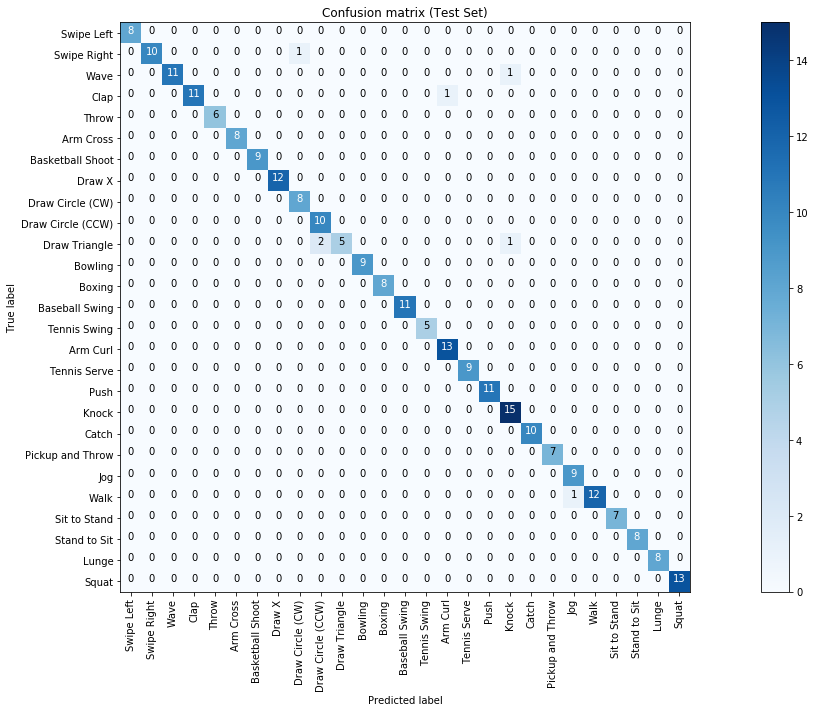

In [11]:
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')

In [12]:
# Compute softmax probabilities
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

predictions2=[]
for i in predictions:
    new = list(softmax(i[1:]))
    predictions2.append(new)
    
predictions2=np.array(predictions2)

train_predictions = model.predict(X_train)
train_predictions2=[]
for i in train_predictions:
    new = list(softmax(i[1:]))
    train_predictions2.append(new)
    
train_predictions2=np.array(train_predictions2)

In [13]:
import pickle

In [14]:
picklesave = open("skeleton_pred_train.pickle", "wb")
pickle.dump(train_predictions2, picklesave)
picklesave.close()

picklesave = open("skeleton_pred_test.pickle", "wb")
pickle.dump(predictions2, picklesave)
picklesave.close()

In [15]:
picklesave = open("y_train.pickle", "wb")
pickle.dump(y_train, picklesave)
picklesave.close()

picklesave = open("y_test.pickle", "wb")
pickle.dump(y_test, picklesave)
picklesave.close()